In [27]:
import torch
from torchvision import datasets, transforms

# Prepare a sample dataset with Torch Vision consisting of
# Clothing images of 10 class

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [28]:
from torch import nn, optim
import torch.nn.functional as F

# Create classifier model with dropout added
# 1 input layer with 784 units (pixels for a 28 x 28 pixel image)
# 3 hidden layers
# 1 output layer with 10 units for 10 classes
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10) # output
        
        # Add dropout rate with 20% probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # No dropout for output layer
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [42]:
# Check the model
model = Classifier()

# Gram a set of images
images, labels = next(iter(testloader))

# Get the class probabilities
probabilities = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(probabilities.shape)

torch.Size([64, 10])


In [30]:
## Train train model with dropout and monitor the training progress 
## with the validation loss and accuracy

model = Classifier()
criterion = nn.NLLLoss()
# Use Stotastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 30
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        # Calculate output
        log_prob = model.forward(images)
        loss = criterion(log_prob, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # turn off gradients to save memory
        with torch.no_grad():
            # Set model to evaluation mode
            model.eval()
            
            for images, labels in testloader:
                log_prob = model(images)
                loss = criterion(log_prob, labels)
                test_loss += loss
                
                # Calculate raw probabilities
                prob = torch.exp(log_prob)
                
                # Get the class with the highest probability as top_class
                top_p, top_class = prob.topk(1, dim=1)
                
                # Check if labels equal the predicted top class
                equals = top_class == labels.view(*top_class.shape)
                
                # Add to the running accuracy total
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        accuracy = accuracy/len(testloader)
        
        print('Epoch: {}/{}..'.format(e+1, epochs),
              'Training loss: {:.3f}.. '.format(running_loss/len(trainloader)),
              'Test loss: {:.3f}..'.format(test_loss/len(testloader)),
              'Accuracy: {:.3f}%'.format(accuracy.item()*100))
        
        # return model to training mode
        model.train()

Epoch: 1/30.. Training loss: 2.144..  Test loss: 1.714.. Accuracy: 43.083%
Epoch: 2/30.. Training loss: 1.381..  Test loss: 1.020.. Accuracy: 63.933%
Epoch: 3/30.. Training loss: 1.007..  Test loss: 0.812.. Accuracy: 71.576%
Epoch: 4/30.. Training loss: 0.854..  Test loss: 0.716.. Accuracy: 74.124%
Epoch: 5/30.. Training loss: 0.769..  Test loss: 0.662.. Accuracy: 74.930%
Epoch: 6/30.. Training loss: 0.714..  Test loss: 0.625.. Accuracy: 76.612%
Epoch: 7/30.. Training loss: 0.677..  Test loss: 0.602.. Accuracy: 77.498%
Epoch: 8/30.. Training loss: 0.652..  Test loss: 0.582.. Accuracy: 78.573%
Epoch: 9/30.. Training loss: 0.626..  Test loss: 0.563.. Accuracy: 79.339%
Epoch: 10/30.. Training loss: 0.607..  Test loss: 0.553.. Accuracy: 79.638%
Epoch: 11/30.. Training loss: 0.589..  Test loss: 0.534.. Accuracy: 80.484%
Epoch: 12/30.. Training loss: 0.575..  Test loss: 0.524.. Accuracy: 80.782%
Epoch: 13/30.. Training loss: 0.558..  Test loss: 0.512.. Accuracy: 81.190%
Epoch: 14/30.. Traini

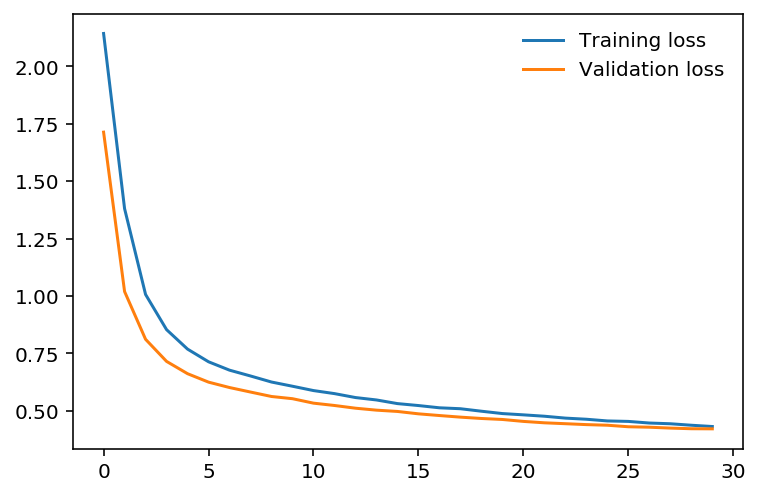

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

# Plot the loss data for training and test sets to make sure the model isn't overfitting
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.legend(frameon=False)

In [36]:
import numpy as np

# Helper for testing
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

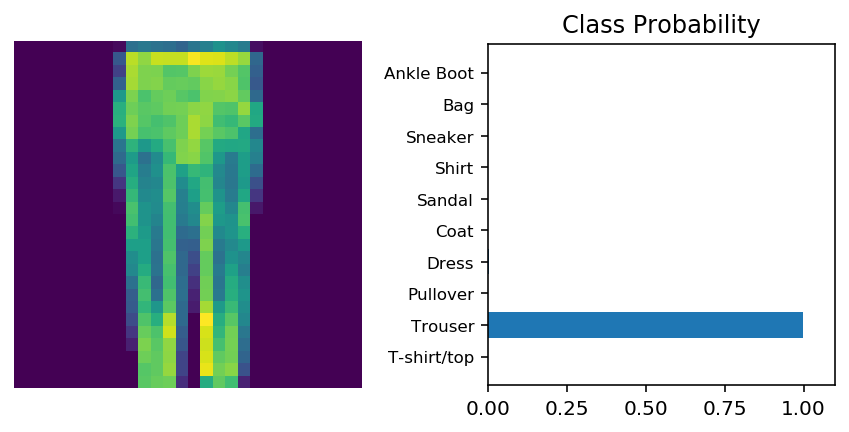

In [41]:
# Test the network
# Re-run this cell to try other images
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

raw_prob = torch.exp(output)

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), raw_prob, version='Fashion')